In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
customers=pd.read_csv('dataset_num.csv')

In [3]:
customers_exl=pd.read_excel('Dataset.xlsx',
sheetname=0,
header=0,
index_col=False,
keep_default_na=True
)

/anaconda3/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [4]:
fraud=customers_exl['FraudFound_P'].values

In [5]:
customers['FraudFound_P']=fraud

In [6]:
df_test = pd.read_csv('output_round1.csv')

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

# Detected Fraud

In [8]:
fraud_count_dict = {}
for rep_number in np.unique(customers['RepNumber']):
    fraud_count_dict[rep_number] = customers[customers['RepNumber']==rep_number]['FraudFound_P'].value_counts()[1]
fraud_count = []
for index, row in customers.iterrows():
    fraud_count.append(fraud_count_dict[row['RepNumber']])
customers['Fraud_Count'] = fraud_count    

In [9]:
from datetime import datetime, timedelta

In [10]:
customers['MonthClaimed'].value_counts()

6     1084
10    1038
9     1005
12     995
11     973
2      970
8      967
5      955
13     944
7      908
4      879
3      846
1        1
Name: MonthClaimed, dtype: int64

In [11]:
def correctMonth(month):
    if month ==2:
        return 1
    elif month==3:
        return 2
    elif month==4:
        return 3
    elif month==5:
        return 4
    elif month==6:
        return 5
    elif month==7:
        return 6
    elif month==8:
        return 7
    elif month==9:
        return 8
    elif month==10:
        return 9
    elif month==11:
        return 10
    elif month==12:
        return 11
    elif month==13:
        return 12
    else:
        return 0
customers['MonthClaimed']=customers['MonthClaimed'].apply(correctMonth) 

In [12]:
index=customers[customers['DayOfWeekClaimed']==1].index[0]
customers.drop(customers[customers['DayOfWeekClaimed']==1].index[0],inplace=True)
#customers.drop(customers[customers['MonthClaimed']==0].index[0],inplace=True)

In [13]:
customers_exl['DayOfWeekClaimed'].value_counts()

Monday       2811
Tuesday      2545
Wednesday    2232
Thursday     2000
Friday       1842
Saturday       94
Sunday         40
0               1
Name: DayOfWeekClaimed, dtype: int64

In [14]:
customers_exl.drop(customers_exl[customers_exl['DayOfWeekClaimed']==0].index[0],inplace=True)

In [15]:
def correctDate(date):
    if date ==2:
        return 1
    elif date==3:
        return 2
    elif date==4:
        return 3
    elif date==5:
        return 4
    elif date==6:
        return 5
    elif date==7:
        return 6
    elif date==8:
        return 7
customers['DayOfWeekClaimed']=customers['DayOfWeekClaimed'].apply(correctDate)    

In [16]:
daydict={
       1 : 'Monday',
       2 : 'Tuesday',
       3 : 'Wednesday',
       4 : 'Thursday',
       5 : 'Friday',
       6 : 'Saturday',
       7 : 'Sunday',
}

In [17]:
def parse_date(year, month_name, week_month, day):
    month = month_name
    first_date = datetime(year, month, 1)
    first_day = first_date.isoweekday()
    first_week_number = first_date.isocalendar()[1]
    if (first_week_number == 52):
        first_week_number = 1
    week_number = first_week_number + week_month - 1
    string_date = str(year)+'-'+str(week_number)+'-'+daydict.get(day)
    date = datetime.strptime(string_date, '%Y-%U-%A')
    return date

# Accident Claim Gap

In [18]:
gap = []
accident_dates = []
claim_dates = []
for index, row in customers.iterrows():
    accident_year = row['Year']
    if (row['Month'] <= row['MonthClaimed']):
        claim_year = accident_year
    else:
        claim_year = accident_year + 1
    
    accident_date = parse_date(accident_year, row['Month'], row['WeekOfMonth'], row['DayOfWeek'])
    claim_date = parse_date(claim_year, row['MonthClaimed'], row['WeekOfMonthClaimed'], row['DayOfWeekClaimed'])
    accident_dates.append(accident_date)
    claim_dates.append(claim_date)
    gap.append(abs((claim_date - accident_date).days))

In [19]:
customers['Accident_Claim_Gap'] = gap

# CLAIM AMOUNT TRUST

In [20]:
vehicle_price_dict = {
    'less than 20000': 20000,
    '20000 to 29000': 24500,
    '30000 to 39000': 34500,
    '40000 to 59000': 49500,
    '60000 to 69000': 64500,
    'more than 69000': 69000
}

In [21]:
claim_trustability = []

In [22]:
for index, row in customers_exl.iterrows():
    ct = vehicle_price_dict[row['VehiclePrice']] - row['ClaimSize']
    claim_trustability.append(ct)

In [23]:
len(claim_trustability)

11564

In [24]:
customers.shape

(11564, 38)

In [25]:
customers['Claim_Amount_Trustability'] = claim_trustability

In [26]:
org_trustability = []


In [27]:
del customers['PolicyNumber']
del customers['Year']
del customers['Month']
del customers['MonthClaimed']
del customers['WeekOfMonth']
del customers['WeekOfMonthClaimed']
del customers['DayOfWeek']
del customers['DayOfWeekClaimed']
del customers['Age_na']
del customers['DriverRating_na']
del customers['PolicyType']

In [28]:
del customers['RepNumber']
del customers['ClaimSize']

In [29]:
Fraud=customers[customers['FraudFound_P']==1]
NotFraud=customers[customers['FraudFound_P']==0]
Y_fraud=Fraud['FraudFound_P'].values
Y_NotFraud=NotFraud['FraudFound_P'].values
del Fraud['FraudFound_P']
del NotFraud["FraudFound_P"]
del customers['FraudFound_P']

In [94]:
X_train_fraud,X_test_fraud,Y_train_fraud,Y_test_fraud=train_test_split(Fraud.values,Y_fraud,test_size=0.5)
X_train_Notfraud,X_test_Notfraud,Y_train_Notfraud,Y_test_Notfraud=train_test_split(NotFraud.values,Y_NotFraud,test_size=0.80)
X_train=np.concatenate([X_train_fraud,X_train_Notfraud])
Y_train=np.concatenate([Y_train_fraud,Y_train_Notfraud])
X_test=np.concatenate([X_test_fraud,X_test_Notfraud])
Y_test=np.concatenate([Y_test_fraud,Y_test_Notfraud])

In [95]:
df_new=pd.DataFrame(X_train)
df_new.columns=customers.columns
df_new['FraudFound_P']=Y_train
df_new = df_new.sample(frac=1).reset_index(drop=True)
Y_train=df_new['FraudFound_P'].values
del df_new['FraudFound_P']
X_train=df_new.values

In [96]:
import lightgbm as lgb
print("LightGBM version: {}".format(lgb.__version__))

LightGBM version: 2.2.2


In [97]:
lgb_train = lgb.Dataset(X_train, Y_train, free_raw_data=False)

In [141]:
parameters = {'num_leaves': 2**6,
              'learning_rate': 0.01,
              'is_unbalance': True,
              'min_split_gain': 0.03,
              'min_child_weight': 1,
              'reg_lambda': 1,
              'subsample': 1,
              'objective':'binary',
              #'device': 'gpu', # comment this line if you are not using GPU
              'task': 'train'
              }
num_rounds = 500

In [143]:
%%time
clf = lgb.train(parameters, lgb_train, num_boost_round=num_rounds)

CPU times: user 5.42 s, sys: 68.3 ms, total: 5.48 s
Wall time: 733 ms


In [148]:
y_prob = clf.predict(X_test)

Y_pred = np.array([0 if i<0.5 else 1 for i in y_prob])

In [101]:
importances = clf.feature_importance()
tick_labels = customers.columns

In [102]:
feature_importances = pd.DataFrame()
feature_importances['Importance'] = importances
feature_importances['Feature'] = tick_labels
feature_importances.sort_values('Importance', inplace=True)

In [103]:
importances = feature_importances['Importance']
tick_labels = feature_importances['Feature']

In [104]:
threshold = 0.035

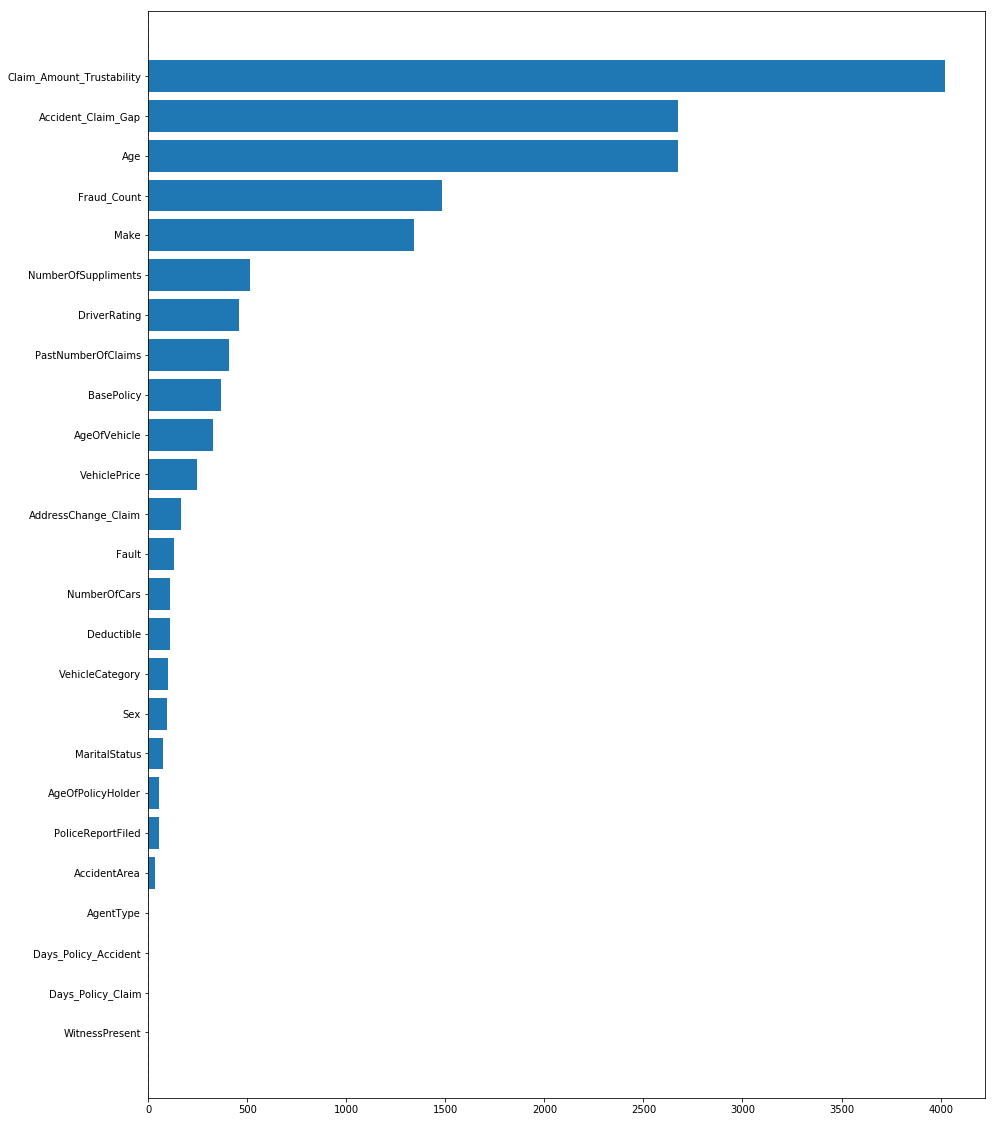

In [105]:
figure = plt.figure(figsize=(15,20))
plt.barh(range(len(importances)), importances, tick_label=tick_labels)
plt.axvline(threshold,color='gray',linestyle='dashed')

In [106]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [119]:
print(accuracy_score(Y_test,Y_pred))
print(confusion_matrix(Y_test,Y_pred))
print(f1_score(Y_test,Y_pred))

0.8264618105449321
[[7303 1401]
 [ 169  174]]
0.18143899895724713


In [147]:
print(accuracy_score(Y_test,Y_pred))
print(confusion_matrix(Y_test,Y_pred))
print(f1_score(Y_test,Y_pred))

0.7996020780369183
[[7035 1669]
 [ 144  199]]
0.18000904568068749
